# Students Do: Predicting Gold Closing Prices

In this activity, you will gain hands-on experience by building an RNN LSTM for predicting gold closing prices using time-series data.

In [249]:
# Initial imports
import numpy as np
import pandas as pd
from stockstats import StockDataFrame as sdf
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
from pathlib import Path
import lib_copy
%matplotlib inline

In [250]:
load_dotenv()

Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8


True

In [251]:
# Fetch Gold prices from QUANDL

response_data = lib_copy.fetch_ohlcv("TSLA")
response_data.index = response_data.index.date
ohlcv = response_data
ohlcv

,open,high,low,close,volume
2020-01-02,422.640,422.64,422.64,422.64,100
2020-01-02,422.710,423.04,422.71,423.04,290
2020-01-02,424.010,424.14,424.01,424.14,200
2020-01-02,424.490,424.94,424.49,424.94,325
2020-01-02,425.010,425.01,425.01,425.01,100
...,...,...,...,...,...
2020-12-31,702.240,705.22,701.13,703.68,47000
2020-12-31,703.676,703.86,698.00,698.00,56779
2020-12-31,698.050,704.94,697.78,704.13,45436
2020-12-31,704.395,706.79,703.02,705.44,88359


In [252]:
def adding_boll_kelt_ewma_dataframe(dataframe):
    lib_copy.bollinger_band_generator(dataframe)
    lib_copy.keltner_channel(dataframe)
    lib_copy.ewma(dataframe)

    return dataframe

In [253]:
everything = adding_boll_kelt_ewma_dataframe(ohlcv)

In [254]:
# Looking for missing values
everything.isnull().sum().sum()

61

In [255]:
# Filling missing values with the previous ones
everything = everything.fillna(method ='pad')
everything

,open,high,low,close,volume,bollinger_band_middle,bollinger_band_std,bollinger_band_upper,bollinger_band_lower,close_-1_s,tr,tr_14_smma,atr,kcmid,kcup,kclo,EMA9,EMA21
2020-01-02,426.770,427.12,425.410,426.30,8372,425.04520,1.359090,427.763380,422.327020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,426.300000,426.300000
2020-01-02,426.330,426.97,426.210,426.46,5158,425.23620,1.268701,427.773602,422.698798,426.30,0.76,0.760000,0.760000,NaN,NaN,NaN,426.332000,426.314545
2020-01-02,426.730,428.37,426.635,428.13,9711,425.49070,1.314651,428.120002,422.861398,426.46,1.91,1.356296,1.356296,NaN,NaN,NaN,426.691600,426.479587
2020-01-02,428.085,428.88,427.970,428.30,8970,425.69870,1.414964,428.528627,422.868773,428.13,0.91,1.196380,1.196380,NaN,NaN,NaN,427.013280,426.645079
2020-01-02,428.680,429.74,428.680,429.59,6389,425.93120,1.646780,429.224759,422.637641,428.30,1.44,1.264213,1.264213,NaN,NaN,NaN,427.528624,426.912799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,702.240,705.22,701.130,703.68,47000,711.72925,5.349815,722.428880,701.029620,702.30,4.09,4.118721,4.118721,711.72925,715.847971,707.610529,708.858680,708.650536
2020-12-31,703.676,703.86,698.000,698.00,56779,711.56625,5.722281,723.010813,700.121687,703.68,5.86,4.243098,4.243098,711.56625,715.809348,707.323152,706.686944,707.682305
2020-12-31,698.050,704.94,697.780,704.13,45436,711.53700,5.760513,723.058026,700.015974,698.00,7.16,4.451448,4.451448,711.53700,715.988448,707.085552,706.175555,707.359368
2020-12-31,704.395,706.79,703.020,705.44,88359,711.41450,5.867212,723.148924,699.680076,704.13,3.77,4.402773,4.402773,711.41450,715.817273,707.011727,706.028444,707.184880


In [256]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [257]:
# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 16
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(everything, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[426.3        426.332      426.6916     427.01328    427.528624
  427.6608992  427.99671936 428.14337549 428.59870039 428.91296031
  429.15836825 429.3446946  429.44175568 429.51940454 429.66352364
  428.48881891 427.76905513 427.3632441  429.49259528 430.81807622
  432.05246098 433.92796878 435.19057503 438.21246002 439.89796802
  441.31837441 442.90469953 444.14375962 445.1610077  445.72680616]
 [426.332      426.6916     427.01328    427.528624   427.6608992
  427.99671936 428.14337549 428.59870039 428.91296031 429.15836825
  429.3446946  429.44175568 429.51940454 429.66352364 428.48881891
  427.76905513 427.3632441  429.49259528 430.81807622 432.05246098
  433.92796878 435.19057503 438.21246002 439.89796802 441.31837441
  442.90469953 444.14375962 445.1610077  445.72680616 446.20344493]
 [426.6916     427.01328    427.528624   427.6608992  427.99671936
  428.14337549 428.59870039 428.91296031 429.15836825 429.3446946
  429.44175568 429.51940454 429.66352364 428.48

In [258]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [259]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [260]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.05250396]
  [0.05252021]
  [0.05270292]
  [0.05286635]
  [0.05312819]
  [0.05319539]
  [0.05336601]
  [0.05344052]
  [0.05367186]
  [0.05383153]
  [0.05395621]
  [0.05405088]
  [0.05410019]
  [0.05413964]
  [0.05421287]
  [0.05361603]
  [0.05325034]
  [0.05304416]
  [0.05412602]
  [0.05479946]
  [0.05542662]
  [0.05637951]
  [0.057021  ]
  [0.05855634]
  [0.0594127 ]
  [0.06013436]
  [0.06094033]
  [0.06156986]
  [0.0620867 ]
  [0.06237416]]

 [[0.05252021]
  [0.05270292]
  [0.05286635]
  [0.05312819]
  [0.05319539]
  [0.05336601]
  [0.05344052]
  [0.05367186]
  [0.05383153]
  [0.05395621]
  [0.05405088]
  [0.05410019]
  [0.05413964]
  [0.05421287]
  [0.05361603]
  [0.05325034]
  [0.05304416]
  [0.05412602]
  [0.05479946]
  [0.05542662]
  [0.05637951]
  [0.057021  ]
  [0.05855634]
  [0.0594127 ]
  [0.06013436]
  [0.06094033]
  [0.06156986]
  [0.0620867 ]
  [0.06237416]
  [0.06261633]]

 [[0.05270292]
  [0.05286635]
  [0.05312819]
  [0.05319539]
  [0.05336601

In [261]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [262]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [263]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [264]:
# Show the model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30, 30)            3840      
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 30)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 30)            7320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 30)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [265]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0149
Epoch 2/10
71/71 [==============================] - 4s 62ms/step - loss: 0.0088
Epoch 3/10
71/71 [==============================] - 4s 55ms/step - loss: 0.0047
Epoch 4/10
71/71 [==============================] - 4s 52ms/step - loss: 0.0033
Epoch 5/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0039
Epoch 6/10
71/71 [==============================] - 4s 54ms/step - loss: 0.0042
Epoch 7/10
71/71 [==============================] - 4s 56ms/step - loss: 0.0037
Epoch 8/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0048
Epoch 9/10
71/71 [==============================] - 4s 56ms/step - loss: 0.0042
Epoch 10/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0028


In [266]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

3.8211674109334126e-05

In [267]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [268]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [269]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = everything.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
2020-09-14,410.77,405.347137
2020-09-14,412.90,406.246887
2020-09-14,416.58,407.100677
2020-09-14,420.00,407.942017
2020-09-14,422.97,408.813507


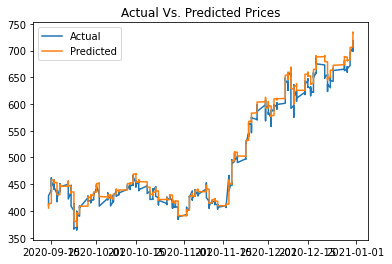

In [270]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted Prices")